# MLP class

In [24]:
import numpy as np

In [25]:
class MLP:
    def __init__(self, layer_sizes, act_fun, out_act_fun_is_linear = True):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_is_linear)
        
        weights = []
        biases = []
        for i in range(self.n_layers - 1):
            weights.append(np.ones((layer_sizes[i], layer_sizes[i + 1])))
            biases.append(np.ones((layer_sizes[i + 1], 1)))
        self.weights = weights
        self.biases = biases
        

    def predict(self, x):
        y = []
        for i in range(len(x)):
            y_temp = x[i]
            for j in range(len(self.weights) - 1):
                y_temp = self.act_fun(np.dot(self.weights[j].T, y_temp) + self.biases[j])
            y_temp = self.out_act_fun(np.dot(self.weights[-1].T, y_temp) + self.biases[-1])
            y.append(y_temp)
        return np.array(y).flatten()
                
    
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            
        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            
        self.act_fun = act_fun

    def set_out_act_fun(self, out_act_fun_is_linear):
        if not out_act_fun_is_linear:
            self.out_act_fun = self.act_fun
            return
        self.out_act_fun = lambda x: x
    

    # def mse(self, x_test, y_test):
    #     return np.mean((self.predict(x_test) - y_test) ** 2)


    

In [26]:
def MSE(y, y_pred):
    return np.mean((y - y_pred) ** 2)

In [27]:
def normalize(data, min = None, max = None):
    if min is None:
        min = np.min(data)

    if max is None:
        max = np.max(data)

    return 2 * (data - min) / (max - min) - 1, min, max    

In [28]:
def denormalize(data, min, max):
    return (data + 1) * (max - min) / 2 + min

# Interactive plotting function

In [29]:
import matplotlib.pyplot as plt
# %matplotlib widget
import pandas as pd

import ipywidgets as widgets
from IPython.display import display

In [30]:
def create_interactive_plot(mlp, x, y):
    def create_sliders(mlp):
        weight_sliders = []
        biases_sliders = []
        containers = []

        for i in range(mlp.n_layers - 1):
            w_layer = []
            for j in range(mlp.layer_sizes[i]):
                for k in range(mlp.layer_sizes[i + 1]):
                    w_layer.append(widgets.FloatSlider(
                        value=mlp.weights[i][j][k], 
                        min=-10000, 
                        max=10000, 
                        step=0.01,
                        description='W_' + str(j+1) + str(k+1),
                        continuous_update=True
                    ))
            weight_sliders.append(w_layer)

            b_layer = []
            for j in range(mlp.layer_sizes[i + 1]):
                b_layer.append(widgets.FloatSlider(
                    value=mlp.biases[i][j], 
                    min=-10000, 
                    max=10000, 
                    step=0.01,
                    description='b_' + str(j+1),
                    continuous_update=True
                ))
            biases_sliders.append(b_layer)

            containers.append(widgets.VBox(w_layer + b_layer))
        return weight_sliders, biases_sliders, containers

    fig, ax = plt.subplots(figsize=(6, 4))
    
    weight_sliders, biases_sliders, containers = create_sliders(mlp)

    def update_plot(change=None):
        for i in range(mlp.n_layers - 1):
            for j in range(mlp.layer_sizes[i]):
                for k in range(mlp.layer_sizes[i + 1]):
                    mlp.set_weigth(i, j, k, weight_sliders[i][j * mlp.layer_sizes[i + 1] + k].value)
            for j in range(mlp.layer_sizes[i + 1]):
                mlp.set_bias(i, j, biases_sliders[i][j].value)

        x_norm, min_x, max_x = normalize(x)
        y_norm, min_y, max_y = normalize(y)

        y_pred = mlp.predict(x_norm)
        y_pred_denorm = denormalize(np.array(y_pred), min_y, max_y)

        ax.clear()
        ax.scatter(x_norm, y_norm, label='Train', color='blue')
        ax.scatter(x_norm, y_pred, label='Prediction', color='green')
        ax.legend()
        ax.title.set_text('MSE: ' + str(MSE(y, y_pred_denorm)))
        fig.canvas.draw_idle()
        return y_pred

    for w_slider, b_slider in zip(weight_sliders, biases_sliders):
        for slider in w_slider + b_slider:
            slider.observe(update_plot, names='value')

    tab = widgets.Tab(children=containers)
    for i in range(len(containers)):
        tab.set_title(i, 'Layer ' + str(i+1))

    update_plot()
    container = widgets.HBox([fig.canvas, tab])
    display(container)

# Steps-large

In [31]:
steps_large_train = pd.read_csv('data/regression/steps-large-training.csv', index_col=0)
steps_large_test = pd.read_csv('data/regression/steps-large-test.csv', index_col=0)

steps_large_train = steps_large_train.to_numpy()
steps_x_train = steps_large_train[:, 0]
steps_y_train = steps_large_train[:, 1]

steps_large_test = steps_large_test.to_numpy()
steps_x_test = steps_large_test[:, 0]
steps_y_test = steps_large_test[:, 1]


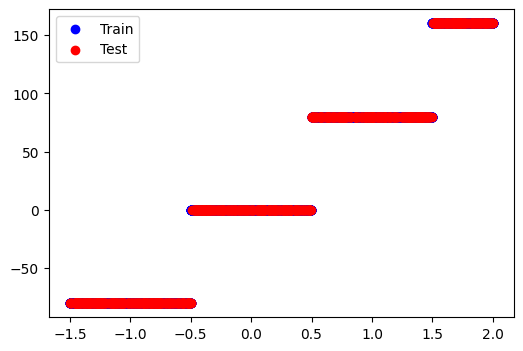

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(steps_x_train, steps_y_train, label='Train', color='blue')
ax.scatter(steps_x_test, steps_y_test, label='Test', color='red')
ax.legend()
plt.show()

In [33]:
mlp = MLP([1, 5, 1], 'sigmoid')

TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the FigureCanvasAgg at '0x15f42ea44a0'.

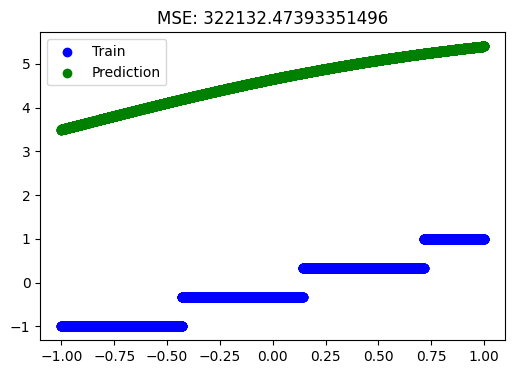

In [34]:
create_interactive_plot(mlp, steps_x_train, steps_y_train)

In [35]:
mlp.set_weigth(0,0,0,5000)
mlp.set_weigth(0,0,1,5000)
mlp.set_weigth(0,0,2,5000)
mlp.set_weigth(0,0,3,0)
mlp.set_weigth(0,0,4,0)

mlp.set_weigth(1,0,0,0.67)
mlp.set_weigth(1,1,0,0.66)
mlp.set_weigth(1,2,0,0.67)
mlp.set_weigth(1,3,0,0)
mlp.set_weigth(1,4,0,0)

mlp.set_bias(0,0,2140)
mlp.set_bias(0,1,-712)
mlp.set_bias(0,2,-3575)
mlp.set_bias(0,3,0)
mlp.set_bias(0,4,0)

mlp.set_bias(1,0,-1)

In [36]:
steps_large_train_norm, steps_x_min, steps_x_max = normalize(steps_x_train)
steps_x_test_norm, _, __ = normalize(steps_x_test, steps_x_min, steps_x_max)

steps_y_train_norm, steps_y_min, steps_y_max = normalize(steps_y_train)

y_train_pred = denormalize(np.array(mlp.predict(steps_large_train_norm)), steps_y_min, steps_y_max)
y_test_pred = denormalize(np.array(mlp.predict(steps_x_test_norm)), steps_y_min, steps_y_max)


C:\Users\kuba_\AppData\Local\Temp\ipykernel_31552\1680053800.py:48: RuntimeWarning: overflow encountered in exp
  act_fun = lambda x: 1 / (1 + np.exp(-x))


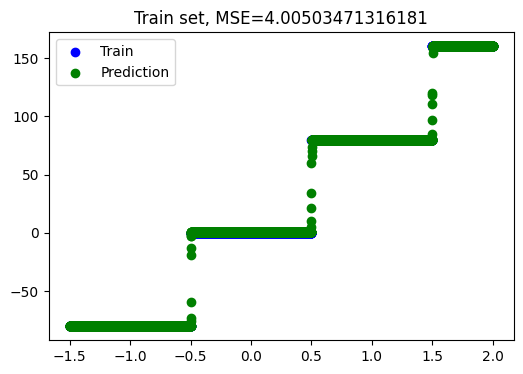

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(steps_x_train, steps_y_train, label='Train', color='blue')
ax.scatter(steps_x_train, y_train_pred, label='Prediction', color='green')
ax.legend()
ax.title.set_text('Train set, MSE=' + str(MSE(steps_y_train, y_train_pred.flatten())))
plt.show()


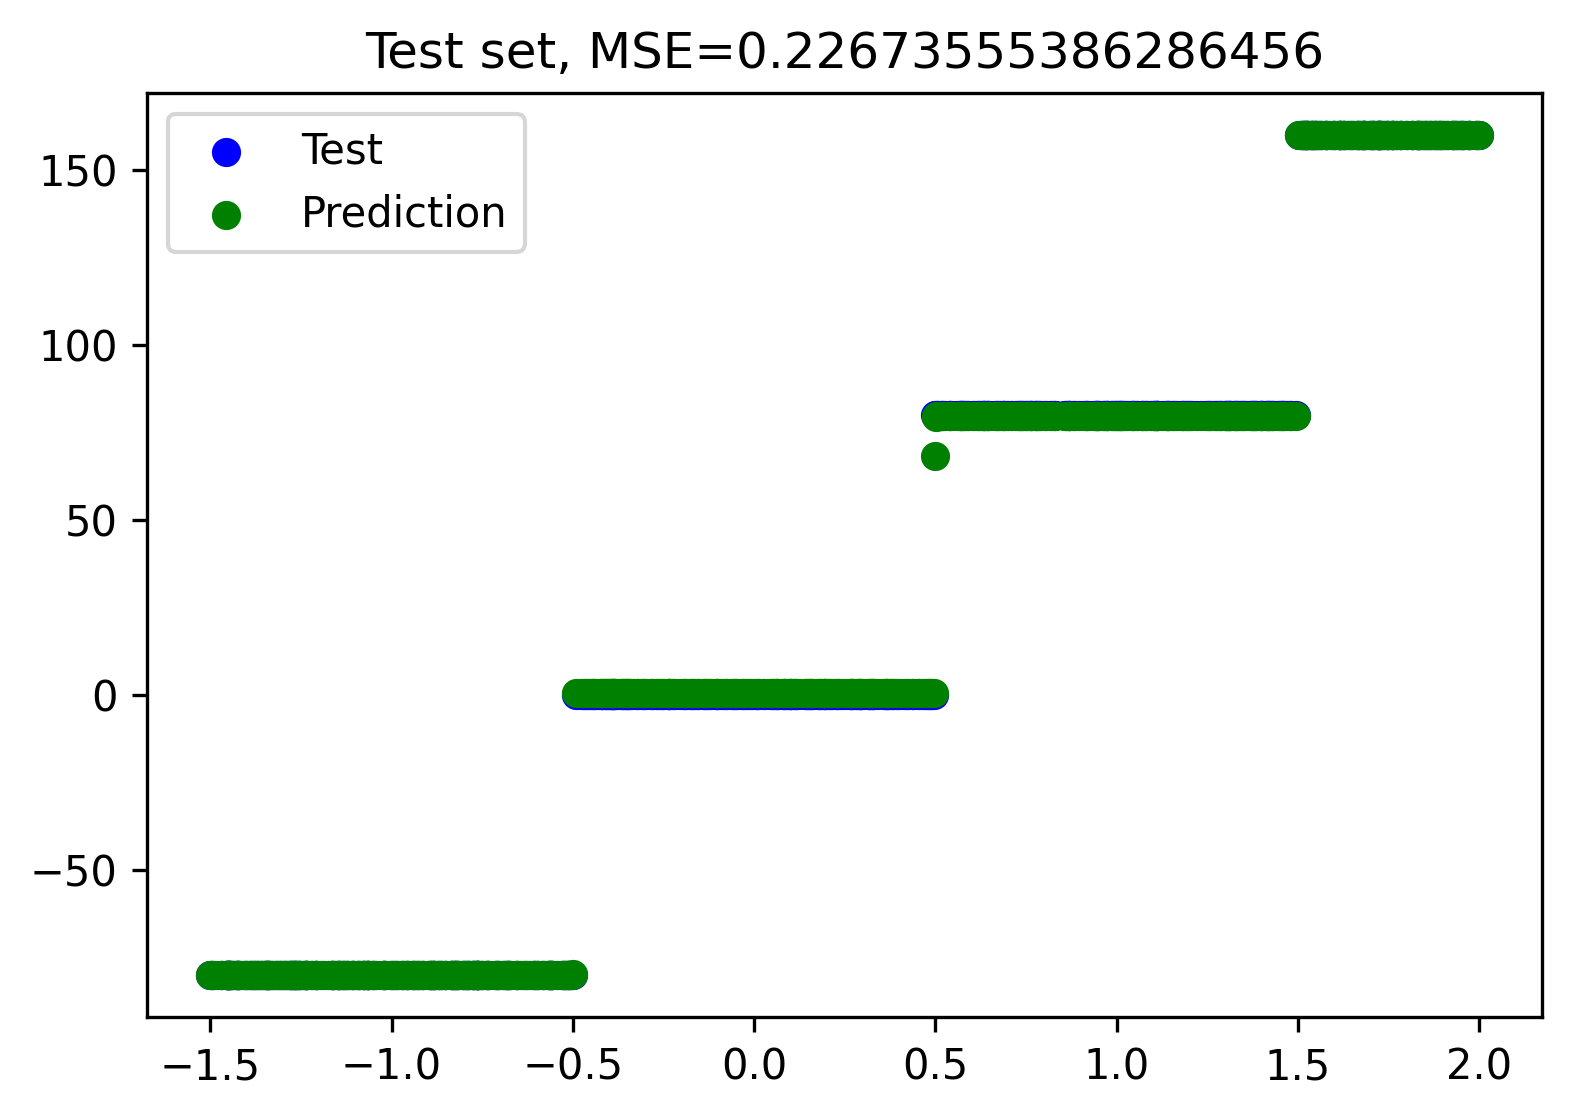

In [38]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

ax.scatter(steps_x_test, steps_y_test, label='Test', color='blue')
ax.scatter(steps_x_test, y_test_pred, label='Prediction', color='green')
ax.legend()
ax.title.set_text('Test set, MSE=' + str(MSE(steps_y_test, y_test_pred.flatten())))
plt.show()


# Square

In [39]:
square_train = pd.read_csv('data/regression/square-simple-training.csv', index_col=0)
square_test = pd.read_csv('data/regression/square-simple-test.csv', index_col=0)

square_x_train = square_train['x'].to_numpy()
square_y_train = square_train['y'].to_numpy()

square_x_test = square_test['x'].to_numpy()
square_y_test = square_test['y'].to_numpy()

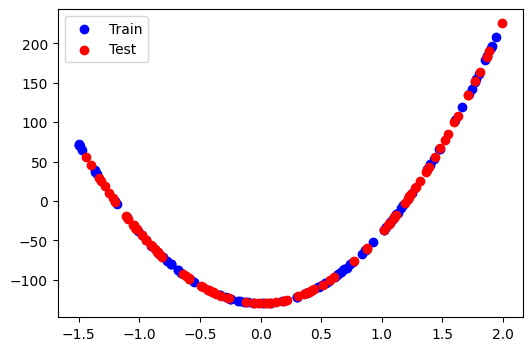

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(square_x_train, square_y_train, label='Train', color='blue')
ax.scatter(square_x_test, square_y_test, label='Test', color='red')
ax.legend()
plt.show()

In [41]:
mlp = MLP([1, 5, 1], 'sigmoid')

TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the FigureCanvasAgg at '0x15f431a7e00'.

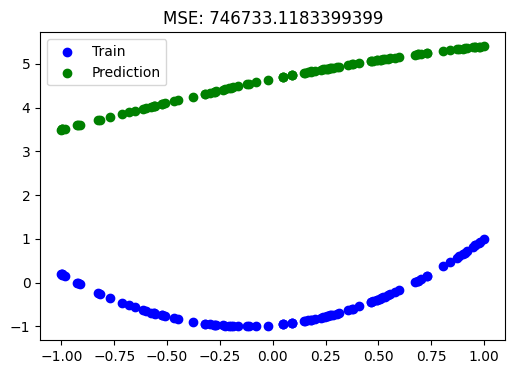

In [42]:
create_interactive_plot(mlp, square_x_train, square_y_train)

In [46]:
mlp.set_weigth(0,0,0,-5)
mlp.set_weigth(0,0,1,-3.05)
mlp.set_weigth(0,0,2,0.3)
mlp.set_weigth(0,0,3,3.8)
mlp.set_weigth(0,0,4,4.75)

mlp.set_bias(0,0,-4.5)
mlp.set_bias(0,1,-2)
mlp.set_bias(0,2,0.2)
mlp.set_bias(0,3,-2)
mlp.set_bias(0,4,-5)

mlp.set_weigth(1,0,0,1.41)
mlp.set_weigth(1,1,0,0.91)
mlp.set_weigth(1,2,0,1.4)
mlp.set_weigth(1,3,0,1.4)
mlp.set_weigth(1,4,0,2.2)

mlp.set_bias(1,0,-2.05)

In [47]:
square_x_train_norm, square_x_min, square_x_max = normalize(square_x_train)
square_x_test_norm, _, __ = normalize(square_x_test, square_x_min, square_x_max)

square_y_train_norm, square_y_min, square_y_max = normalize(square_y_train)

y_train_pred = denormalize(np.array(mlp.predict(square_x_train_norm)), square_y_min, square_y_max)
y_test_pred = denormalize(np.array(mlp.predict(square_x_test_norm)), square_y_min, square_y_max)

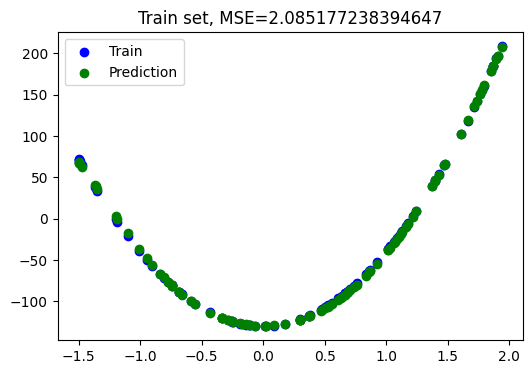

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(square_x_train, square_y_train, label='Train', color='blue')
ax.scatter(square_x_train, y_train_pred, label='Prediction', color='green')
ax.legend()
ax.title.set_text("Train set, MSE=" + str(MSE(square_y_train, y_train_pred)))
plt.show()

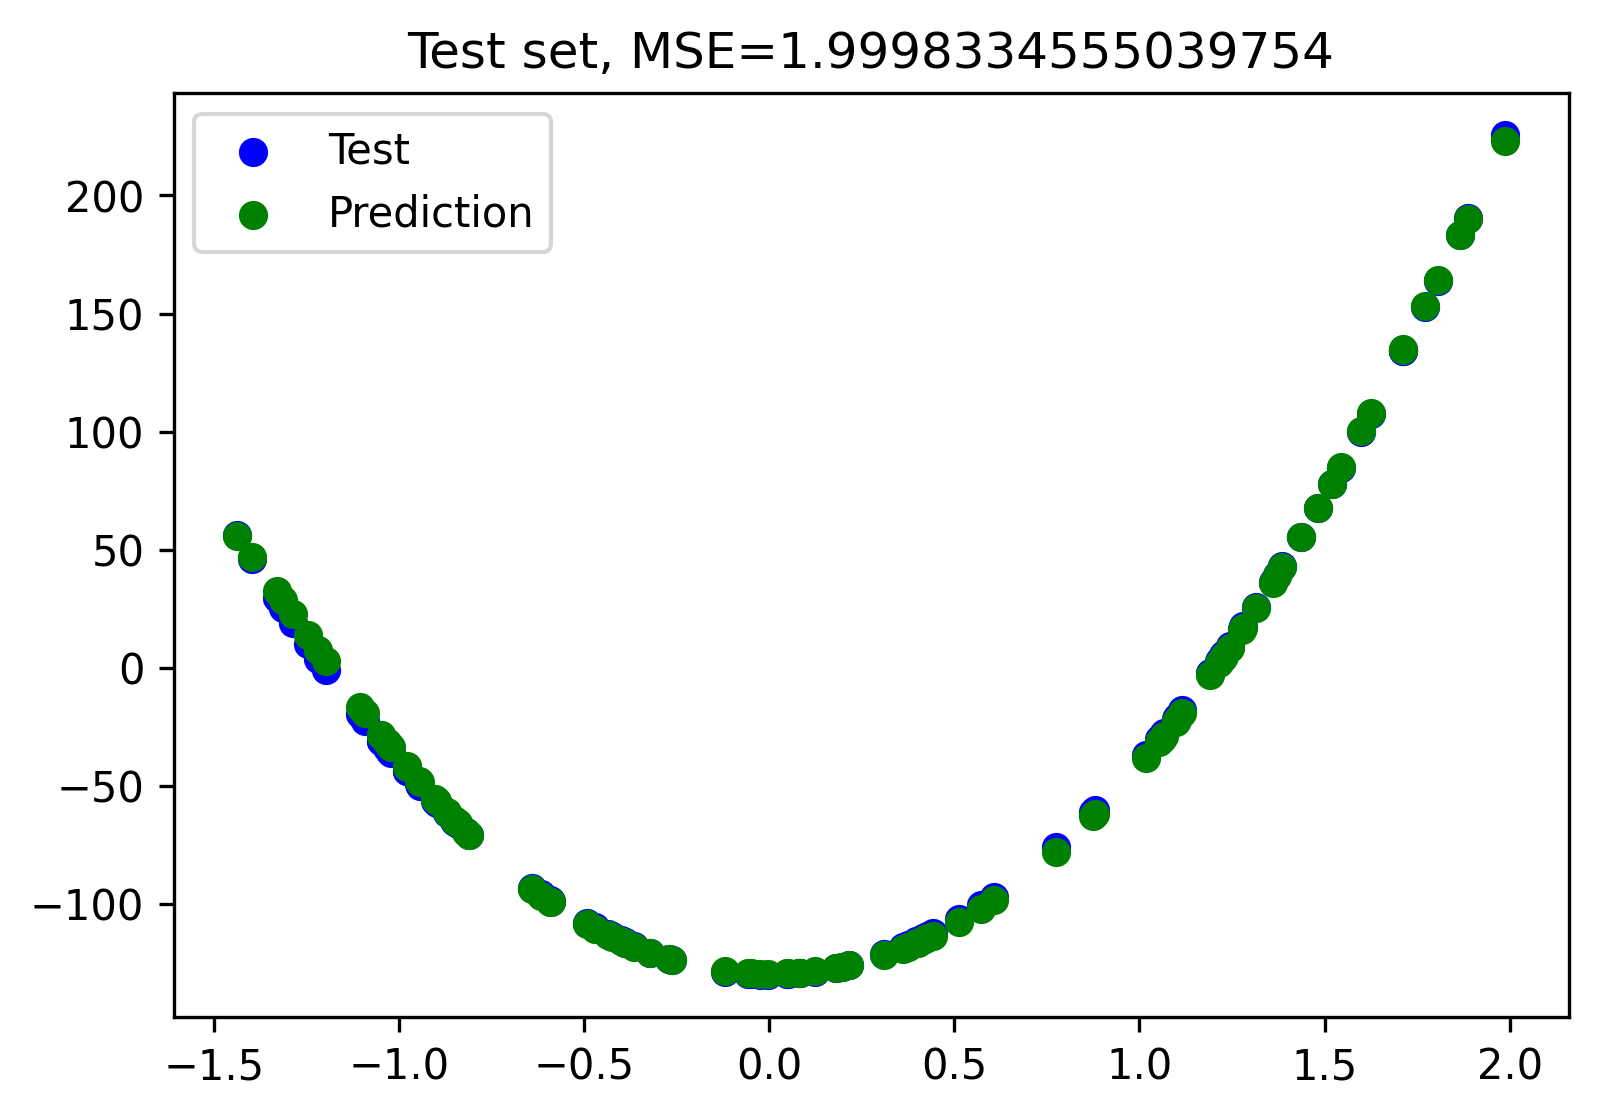

In [49]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

ax.scatter(square_x_test, square_y_test, label='Test', color='blue')
ax.scatter(square_x_test, y_test_pred, label='Prediction', color='green')
ax.legend()
ax.title.set_text('Test set, MSE=' + str(MSE(square_y_test, y_test_pred.flatten())))

plt.show()